In [1]:
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from alpaca_trade_api.rest import REST, TimeFrame
import hvplot.pandas
from scipy.interpolate import interp1d
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def fetch_stock_data(start_date, end_date, tickers, timeframe = '1Day'):
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    api = REST(alpaca_api_key, alpaca_secret_key, base_url = 'https://paper-api.alpaca.markets')
    start_date_iso = pd.Timestamp(start_date, tz = 'America/New_York').isoformat()
    end_date_iso = pd.Timestamp(end_date, tz = 'America/New_York').isoformat()
    
    df_ticker = api.get_bars(tickers, TimeFrame.Day, start = start_date_iso, end = end_date_iso).df
    dfs = {}
    for ticker in tickers:
        ticker_df = df_ticker.loc[df_ticker.symbol == ticker].drop('symbol', axis = 1)
        ticker_df = ticker_df['close']
        dfs[ticker] = ticker_df
    new_df = pd.concat(dfs.values(), axis = 1, keys = tickers)
    
    new_df.reset_index(inplace = True)
    new_df.timestamp = new_df.timestamp.dt.date
    new_df.set_index('timestamp', inplace = True)
    new_df.index = pd.to_datetime(new_df.index)
    return new_df

def gen_random_weights(num_weights):
    weights = [random.random() for _ in range(num_weights)]
    normalized_weights = [round(w/sum(weights), 4) for w in weights]
    if sum(normalized_weights) != 1:
        return gen_random_weights(num_weights)
    return normalized_weights

def weights(stock_list, num_simulations):
    all_lists = []
    num_assets = len(stock_list)
    for _ in range(num_simulations):
        random_weights = gen_random_weights(num_assets)
        all_lists.append(random_weights)
    if num_simulations == 1:
        all_lists = all_lists[0]
    return all_lists



In [3]:
# This function was created to create the range graph for mc_sim function
def calculate_percentile(row, percentile):
    return np.percentile(row, percentile)

def portfolio_return(df, weight_list):
    # Calculate the daily returns of stocks
    daily_return = df.pct_change().dropna()
    # Calculate the mean of daily returns, and dot product it with their weights to find the portfolio mean
    portfolio_mean = daily_return.dot(weight_list).mean() * 252
    return portfolio_mean

def portfolio_risk(df, weight_list):
    # Calculate the daily retuns of stocks
    daily_return = df.pct_change()
    # Find covariance matrix of the stocks
    cov_matrix = daily_return.cov()
    # Change weight lists into a vector
    weight_mat = np.matrix(weight_list)
    # Use the formula for portfolio risk (standard deviation) which is (w * sigma * w.T)^(0.5) where w is the weight vector and sigma is the covariance matrix
    portfolio_risk = np.sqrt(np.dot(np.dot(weight_mat, cov_matrix), weight_mat.T)).item() * np.sqrt(252)
    return portfolio_risk

def mc_sim(df, weight_list, timeframe, nsims, investment_amount = 1, kind = 'line'):
    # Calulate the portfolio return and risk
    port_return = portfolio_return(df, weight_list) / 252
    port_risk = portfolio_risk(df, weight_list) / np.sqrt(252)
    # Create a framework for all the simulations
    all_simulations = np.full(shape = (timeframe, nsims), fill_value = 0.0)
    # For each simulation, it generates one numpy array, assigns randomless according to the portfolio return and risk, then finds cumulative return of that simulation.
    # Each created simulation then will be interted into the all_simulations framework
    for i in range(0, nsims):
        one_simulation = np.ones(shape = (timeframe, 1))
        rand = np.random.normal(port_return, port_risk, timeframe).T.reshape((timeframe,1))
        simulations = np.cumprod(one_simulation + rand) * investment_amount
        all_simulations[:,i] = simulations
    # Convert the created simulations into dataframe
    sim_df = pd.DataFrame(all_simulations)
    # If line is chosen, line graphs of all the simulations will be displayed
    if kind == 'line':
        plt.plot(all_simulations)
        plt.title('Monte Carlo Simulation of portfolio')
        plt.xlabel('Days')
        plt.ylabel('Portfolio value')
    # If kde is chosen, the KDE plot of the simulations' last day will be displated
    elif kind == 'kde':
        ax = sim_df.iloc[-1,:].hvplot.kde(alpha = 0.1, title = 'KDE plot of the end result of Monte Carlo Simulation', yformatter = '%.5f', frame_width = 700, frame_height = 400)
        display(ax)
    # If range is chosen, graph that has confidence intervals and interpolated median line is drawn
    elif kind == 'range':
        sim_df_copy = sim_df.copy()
        # 2.5 and 97.5 will form 95% CI, and 25 and 75 will form 50% CI range
        percentiles = [2.5, 25, 75, 97.5]
        # Find median for each day's simulation results
        sim_df_copy['median'] = sim_df_copy.median(axis = 1)
        # Find percentiles for each day's simulation results using the above percentile list
        for i in range(len(percentiles)):
            sim_df_copy[f'percentile_{i}'] = sim_df_copy.iloc[:,:-(i+1)].apply(lambda row: calculate_percentile(row, percentiles[i]), axis = 1)
        
        # Since actual median and percentile values will draw rough lines, scipy.interpolate interp1d was used to smooth those lines for better presentation
        x = np.linspace(0, sim_df_copy.shape[0], sim_df_copy.shape[0])
        smooth_x = np.linspace(0, sim_df_copy.shape[0], 3)

        f_1 = interp1d(x, sim_df_copy['percentile_0'], kind='cubic')
        f_2 = interp1d(x, sim_df_copy['percentile_1'], kind = 'cubic')
        f_3 = interp1d(x, sim_df_copy['percentile_2'], kind = 'cubic')
        f_4 = interp1d(x, sim_df_copy['percentile_3'], kind = 'cubic')
        f_5 = interp1d(x, sim_df_copy['median'], kind = 'cubic')

        y_1_smooth = f_1(smooth_x)
        y_2_smooth = f_2(smooth_x)
        y_3_smooth = f_3(smooth_x)
        y_4_smooth = f_4(smooth_x)
        y_5_smooth = f_5(smooth_x)
        # Plot all the smoothed lines and original simulation line graph on the same plot.
        fig, ax = plt.subplots()

        plt.plot(sim_df, alpha = 0.05)
        ax.plot(smooth_x, y_1_smooth, alpha = 0)
        ax.plot(smooth_x, y_2_smooth, alpha = 0)
        ax.plot(smooth_x, y_3_smooth, alpha = 0)
        ax.plot(smooth_x, y_4_smooth, alpha = 0)
        ax.plot(smooth_x, y_5_smooth, alpha = 1, color = 'k', label = 'Median')
        ax.axhline(y = investment_amount, color = 'r', alpha = 0.4, linestyle = '--')

        ax.fill_between(smooth_x, y_1_smooth, y_4_smooth, alpha = 0.2, label = '95% CI')
        ax.fill_between(smooth_x, y_2_smooth, y_3_smooth, alpha = 0.4, label = '50% CI')
        plt.legend()
        plt.title('Monte Carlo simulation with confidence intervals')
        plt.xlabel('Time (days)')
        plt.ylabel('Portfolio value')
    
    return sim_df

def mc_sim_comparison(df, df2, timeframe, nsims, my_weights, your_weights, investment_amount = 1):
    # This function compares two different simulations
    # Show first simulation
    plt.figure()
    df_1 = mc_sim(df, my_weights, timeframe, nsims, investment_amount)
    plt.title('Portfolio 1')
    # Show second simulation
    plt.figure()
    df_2 = mc_sim(df2, your_weights, timeframe, nsims, investment_amount)
    plt.title('Portfolio 2')
    # Show the KDE plots of each simulations of their ending days together
    plt.figure()
    sns.kdeplot(df_1.iloc[-1,:], shade = True, alpha = 0.1, label = 'Portfolio 1')
    sns.kdeplot(df_2.iloc[-1,:], shade = True, alpha = 0.1, label = 'Portfolio 2')
    plt.title('Comparison of KDE plots for each portfolio')
    plt.legend()

def actual_return_plot(df, weight_list, timeframe, investment_amount = 1):
    # Using the dataframe, fetch the stock list data
    stock_list = df.columns.tolist()
    # Since we are finding actual returns of our potfolio afterwards, start date will be the last date of the original dataframe
    start_date = df.index[-1]
    end_date = start_date + dt.timedelta(timeframe)
    # Input dates are in string format so converting datetime types to string types
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')
    # Get the actual stock data for the future dates, find portfolio returns, and plot it
    new_df = fetch_stock_data(start_date, end_date, stock_list)
    daily_returns = new_df.pct_change().dropna()
    port_daily = np.cumprod(daily_returns.dot(weight_list) + 1) * investment_amount
    port_daily = port_daily.reset_index().drop(['timestamp'], axis = 1)
    plt.plot(port_daily, label = 'Actual return', linewidth = 1.5, color = 'lime')
    plt.legend()

def yearly_portfolio_info(df, weight_list):
    # Only extract Year data from the index
    new_df = df.reset_index()
    new_df.timestamp = new_df.timestamp.dt.year
    new_df.set_index('timestamp', inplace = True)
    # Loop through the dataframe year by year, calculate portfolio returns and risks, then store those info into a list. Column list contains the year information
    yearly_returns = []
    yearly_risks = []
    column_list = []
    for i in range(new_df.index.nunique()):
        yearly_df = new_df.loc[new_df.index == new_df.index.unique()[i]]
        yearly_returns.append(portfolio_return(yearly_df, weight_list))
        yearly_risks.append(portfolio_risk(yearly_df, weight_list))
        column_list.append(new_df.index.unique()[i])
    # Put all the informations into a single dataframe
    final_df = pd.DataFrame([yearly_returns, yearly_risks], index = ['Yearly return', 'Yearly risk'], columns = column_list)
    # Change the orientation and multiply by 100 to show values in percentage
    final_df = final_df.T * 100
    plot = final_df.hvplot.bar(frame_width = 700, frame_height = 450, rot = 90, ylabel = 'Values (%)', xlabel = 'Year', title = 'Yearly portfolio risks and returns')
    display(plot)

def return_vs_risk_graph(df, nsims, my_weights):
    weight_list = weights(df.columns.tolist(), nsims)
    return_list = []
    std_dev_list = []

    for i in weight_list:
        return_list.append(portfolio_return(df, i))
        std_dev_list.append(portfolio_risk(df, i))
    new_df = pd.DataFrame([return_list, std_dev_list], index = ['portfolio_return', 'portfolio_risk'])
    new_df = new_df.T * 100 
    new_df['sharpe_ratio'] = new_df.portfolio_return / new_df.portfolio_risk
    
    safest_portfolio_index = new_df[new_df.portfolio_risk == new_df.portfolio_risk.min()].index[0]
    safest_portfolio_weights = weight_list[safest_portfolio_index]
    best_portfolio_index = new_df[new_df.sharpe_ratio == new_df.sharpe_ratio.max()].index[0]
    best_portfolio_weights = weight_list[best_portfolio_index]
    
    print(f'Your portfolio consists of: '),
    for i in range(df.shape[1]):
        print(f'{(my_weights[i] * 100):.2f}% of {df.columns[i]}'),
    print('-'*30)
    print(f'Suggested portfolio consists of: '),
    for i in range(df.shape[1]):
        print(f'{(best_portfolio_weights[i] * 100):.2f}% of {df.columns[i]}'),
    print('-'*30) 
    print(f'Safest portfolio consists of: '),
    for i in range(df.shape[1]):
        print(f'{(safest_portfolio_weights[i] * 100):.2f}% of {df.columns[i]}'),
    print('-'*30)
    plt.figure(figsize = (10,7))
    plt.scatter(x = new_df.portfolio_risk, y = new_df.portfolio_return, s = 0.3)
    plt.scatter(x = portfolio_risk(df, safest_portfolio_weights) * 100, y = portfolio_return(df, safest_portfolio_weights) * 100, color = 'mediumseagreen', label = 'Safest point')
    plt.scatter(x = portfolio_risk(df, best_portfolio_weights) * 100, y = portfolio_return(df, best_portfolio_weights) * 100, color = 'gold', label = 'Suggested point')
    plt.scatter(x = portfolio_risk(df, my_weights) * 100, y = portfolio_return(df, my_weights) * 100, color = 'k', label = 'Your portfolio', marker = '*')
    plt.xlabel('Risk (%)')
    plt.ylabel('Return (%)')
    plt.title('Return (%) vs. Risk (%)')
    plt.legend()

In [4]:
load_dotenv()

True

In [5]:
stock_list = ['AAPL', 'KO', 'SBUX', 'WMT']
df = fetch_stock_data('2016-01-01', '2019-12-31', stock_list)

In [6]:
df

,AAPL,KO,SBUX,WMT
timestamp,,,,
2016-01-04,105.35,42.40,58.260,61.46
2016-01-05,102.71,42.55,58.650,62.92
2016-01-06,100.70,42.32,58.130,63.55
2016-01-07,96.45,41.62,56.690,65.03
2016-01-08,96.96,41.51,56.630,63.54
...,...,...,...,...
2019-12-24,284.27,54.71,88.520,119.51
2019-12-26,289.91,55.02,88.075,119.52
2019-12-27,289.80,55.35,88.130,119.59


In [7]:
stock_list2 = ['CAT', 'WMT', 'NVDA', 'DAL', 'NKE']
df_2 = fetch_stock_data('2017-01-01', '2019-01-01', stock_list2)

In [8]:
df_2

,CAT,WMT,NVDA,DAL,NKE
timestamp,,,,,
2017-01-03,93.99,68.66,102.01,49.48,51.98
2017-01-04,93.57,69.06,104.39,50.70,53.07
2017-01-05,93.00,69.21,101.74,49.73,53.06
2017-01-06,93.04,68.26,103.10,49.68,53.91
2017-01-09,92.37,68.71,107.28,49.69,53.38
...,...,...,...,...,...
2018-12-24,116.95,85.82,127.04,47.96,68.10
2018-12-26,124.76,90.41,133.10,50.41,73.01
2018-12-27,126.67,91.59,131.17,50.50,73.67


In [9]:
my_weight = weights(stock_list,1)
your_weight = weights(stock_list2,1)

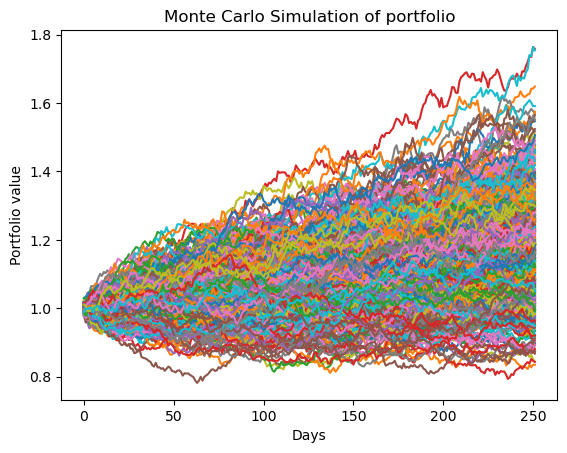

In [10]:
a = mc_sim(df, my_weight, 252, 500)

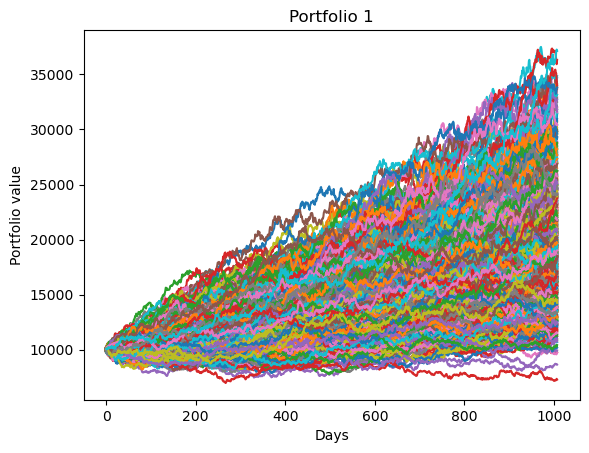

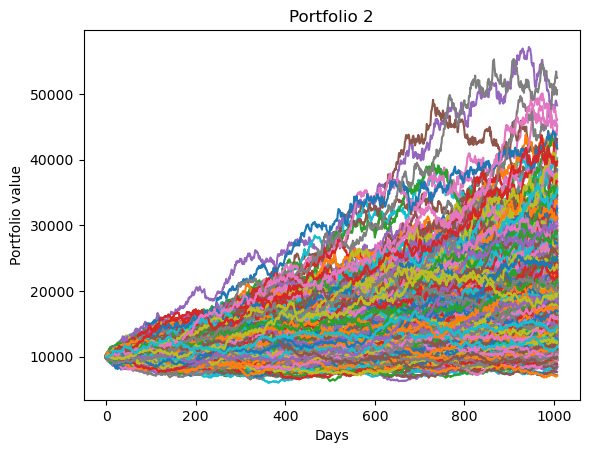

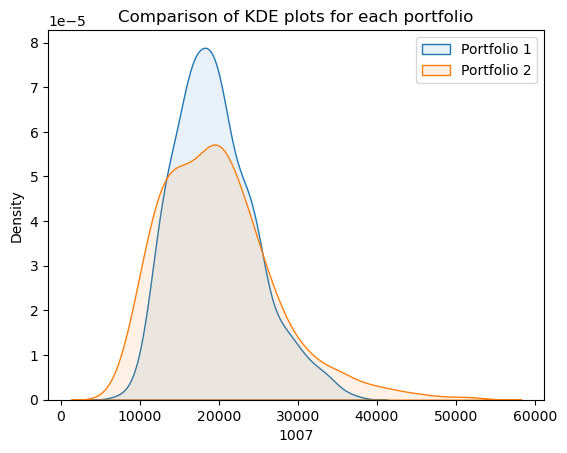

In [11]:
mc_sim_comparison(df, df_2, 252*4, 700, my_weight, your_weight, 10000)

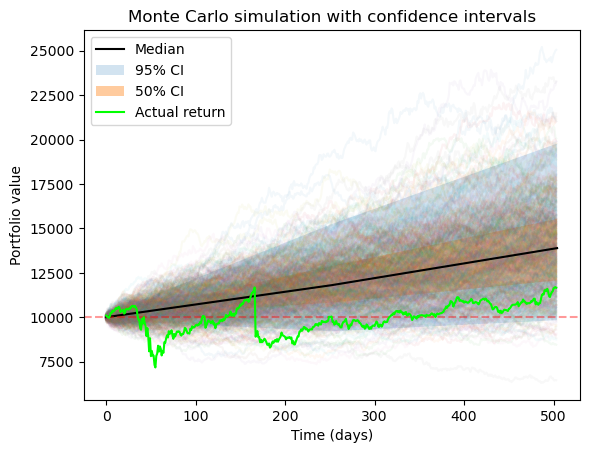

In [12]:
a = mc_sim(df, my_weight, 252*2, 500, investment_amount = 10000, kind = 'range')
actual_return_plot(df, my_weight, 365*2, investment_amount = 10000)

N-asset portfolio risk and return calculation: https://youtu.be/Yqn5ypsCv3g?si=i7tPpsnSzk9BQLww <br>
Monte carlo simulation python: https://youtu.be/6-dhdMDiYWQ?si=xPIXBTUSb3Y6vbjw <br>
Interpolate: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html and ChatGPT <br>
Apply lambda: ChatGPT <br>
Timestamp change to datetime: https://docs.python.org/3/library/datetime.html <br>
Datetime to string: https://www.programiz.com/python-programming/datetime/strftime <br>
Drawing a horizontal line: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html <br>


In [13]:
yearly_portfolio_info(df, my_weight)

:Bars   [index,Variable]   (value)

Your portfolio consists of: 
31.36% of AAPL
31.53% of KO
29.44% of SBUX
7.67% of WMT
------------------------------
Suggested portfolio consists of: 
44.03% of AAPL
10.23% of KO
5.57% of SBUX
40.17% of WMT
------------------------------
Safest portfolio consists of: 
13.64% of AAPL
49.91% of KO
14.89% of SBUX
21.56% of WMT
------------------------------


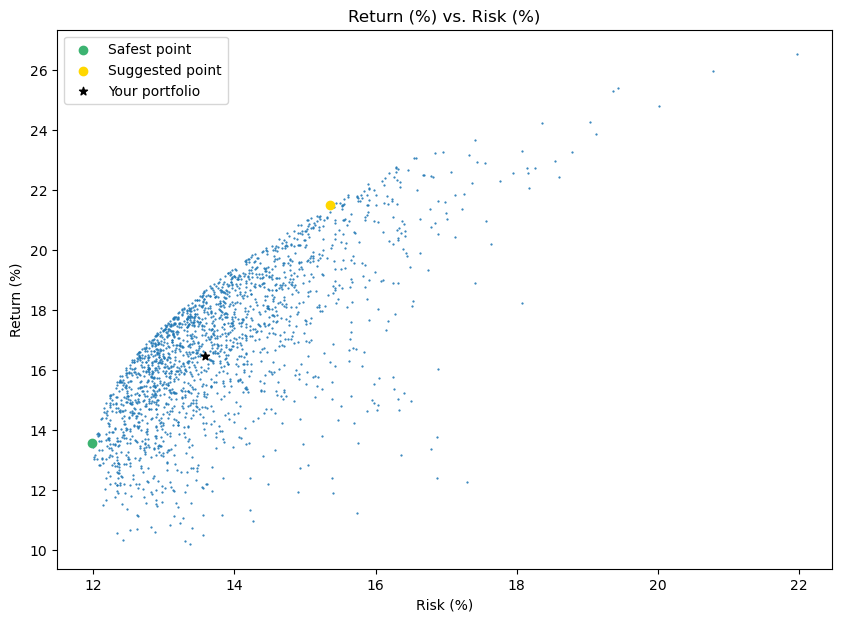

In [14]:
return_vs_risk_graph(df, 2000, my_weight)